In [1]:
from spkit import bkt
import pandas as pd
import re
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

In [2]:
%load_ext autoreload

In [10]:
%autoreload 1

UsageError: Line magic function `%autoreload` not found.


In [ ]:
%aimport spkit.bkt

### Reading KDD train file
Drop rows with null in any of the important columns

In [2]:
folder = 'data/kdd/2008-2009'

### Fitting data

In [3]:
with open('%s/kdd_2008_2009_df.pkl' % folder, 'rb') as pklfile:
    df = pickle.load(pklfile)
with open('%s/kdd_2008_2009_q_matrix.pkl' % folder, 'rb') as pklfile:
    q_matrix = pickle.load(pklfile)

In [4]:
df.shape

(6442137, 10)

In [5]:
q_matrix.shape

(819699, 536)

In [6]:
%%time
# Data matrix
data = df[['Correct First Attempt', 'Anon Student Id', 'question_id']].values.tolist()

Wall time: 3.98 s


In [8]:
%%time
# Instantiate model
model = bkt.BKT()
model.fit(data, q_matrix)

hmm_files/cbcf4debb158451a930e69a6eb0dcb90
Wall time: 4min 23s


In [9]:
students = df['Anon Student Id'].unique().tolist()
len(students)

3292

In [10]:
with open('%s/kdd_2008_2009_students.pkl' % folder, 'wb') as pklfile:
    pickle.dump(students, pklfile)
with open('%s/kdd_2008_2009_model.pkl' % folder, 'wb') as pklfile:
    pickle.dump(model, pklfile)

In [16]:
%%time
data_arr = np.asarray(data)
rmse = 0
n = 0
score_df = []
learning_state = {}
outcome_all = []
predicted_proba = []
for student in students:
    student_idx = np.where(data_arr[:,1] == student)
    outcome = data_arr[student_idx, 0].astype('int64')
    outcome_all += outcome.tolist()[0]
    question_id = data_arr[student_idx, 2].astype('int64')
    data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
    predicted = model.predict_proba(data_student, q_matrix)
    predicted_proba += predicted[:,1].tolist()
    s_aic, s_bic, s_rmse, s_acc = model.score()
    fpr, tpr, _ = roc_curve(outcome.flatten(), predicted[:,1], pos_label=1)
    auc_score = auc(fpr, tpr)
    score_df.append({"student": student,
                     "AIC": s_aic,
                     "BIC": s_bic,
                     "RMSE": s_rmse,
                     "Acc": s_acc,
                     "n questions": model.n_questions,
                     "LL": model.loglikelihood.sum(),
                     "correct_outcome": np.where(outcome == 1)[1].shape[0],
                     "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                     "AUC": auc_score})
    #learning_state[student] = model.learning_state

C:\Users\lmoraes\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\lmoraes\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\lmoraes\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Wall time: 20min 23s


In [17]:
score = pd.DataFrame.from_dict(score_df)

In [18]:
with open('%s/kdd_2008_2009_score.pkl' % folder, 'wb') as pklfile:
    pickle.dump(score, pklfile)
#with open('%s/kdd_2005_2005_learning_state.pkl' % folder, 'wb') as pklfile:
#    pickle.dump(learning_state, pklfile)

In [19]:
rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
rmse_avg = score['RMSE'].mean()
rmse_std = score['RMSE'].std()

In [20]:
print("RMSE de treino: %.2f" % rmse_train)
print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))

RMSE de treino: 0.36
RMSE médio: 0.40 +- 0.07


In [21]:
acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
acc_avg = score['Acc'].mean()
acc_std = score['Acc'].std()

In [22]:
print("Acc de treino: %.2f" % acc_train)
print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))

Acc de treino: 0.81
Acc médio: 0.74 +- 0.15


In [23]:
fpr, tpr, thresholds = roc_curve(outcome_all, predicted_proba, pos_label=1)
auc_score = auc(fpr, tpr)
auc_avg = score['AUC'].mean()
auc_std = score['AUC'].std()

# Sensitivity = tpr = TP/(TP+FN)
# Specificity = 1-fpr = TN/(TN+FP)
# Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
J_stats = tpr - fpr
J_opt_thresholds = thresholds[np.argmax(J_stats)]
print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)

Youden's optimum threshold: 0.83


In [24]:
print("AUC de treino: %.2f" % auc_score)
print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))

AUC de treino: 0.73
AUC médio: 0.69 +- 0.09


Recalculating accuracy after adjusting cutoff point with Youden's Index

In [25]:
estimated_outcome = np.where(np.asarray(predicted_proba) > J_opt_thresholds, 1, 0)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.6294184678158816

In [26]:
# Save threshold
with open('%s/kdd_2008_2009_threshold.pkl' % folder, 'wb') as pklfile:
    pickle.dump(J_opt_thresholds, pklfile)

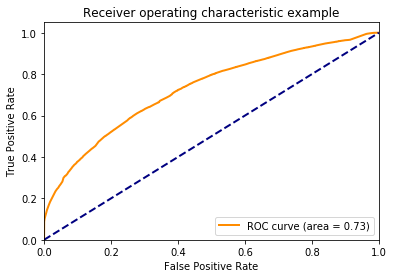

In [27]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Comparing accuracy to random baseline

In [29]:
n_questions = score['n questions'].sum()
p = score['correct_outcome'].sum()/n_questions
# Save p
with open('%s/kdd_2008_2009_p.pkl' % folder, 'wb') as pklfile:
    pickle.dump(p, pklfile)

estimated_outcome = np.random.binomial(1, p, n_questions)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.7384080779405964

In [30]:
score.sort_values(["AUC"], ascending=False)

,student,AIC,BIC,RMSE,Acc,n questions,LL,correct_outcome,incorrect_outcome,AUC
292,stu_d0530f38dd,4302.756146,4186.787506,0.648509,0.142857,7,-7.378073,6,1,1.0
322,stu_52acf1f373,4291.608862,2359.033609,0.455006,0.666667,3,-1.804431,1,2,1.0
1919,stu_e16ccb82a7,4297.033909,3850.566211,0.527457,0.500000,6,-4.516954,3,3,1.0
2722,stu_89a8cd0b97,4326.048205,8590.430000,0.334827,0.814815,54,-19.024102,52,2,1.0
1266,stu_75dcf55c12,4295.433380,3848.965682,0.463600,0.666667,6,-3.716690,2,4,1.0
...,...,...,...,...,...,...,...,...,...,...
2873,stu_9d06de42ae,4302.447674,3855.979976,0.700000,0.000000,6,-7.223837,6,0,NaN
2875,stu_2db80775a4,4336.997628,6771.497227,0.653048,0.086957,23,-24.498814,23,0,NaN
2876,stu_194c917f07,4302.117696,3855.649998,0.691528,0.000000,6,-7.058848,6,0,NaN
2900,stu_6f1e1519cc,4302.117696,3855.649998,0.691528,0.000000,6,-7.058848,6,0,NaN


In [31]:
score.sort_values(["Acc"], ascending=False)

,student,AIC,BIC,RMSE,Acc,n questions,LL,correct_outcome,incorrect_outcome,AUC
1966,stu_257e9e7014,4290.960099,2975.175209,0.309350,1.0,4,-1.480050,0,4,NaN
1323,stu_1241e78717,4289.440848,1487.548403,0.302477,1.0,2,-0.720424,0,2,NaN
2263,stu_8f126c4ab8,4288.713350,0.713350,0.300000,1.0,1,-0.356675,0,1,NaN
2020,stu_b3d0d32ad6,4289.291417,1487.398972,0.276122,1.0,2,-0.645709,0,2,NaN
1959,stu_6fd686a1de,4289.426700,1487.534255,0.300000,1.0,2,-0.713350,0,2,NaN
...,...,...,...,...,...,...,...,...,...,...
2147,stu_9e49bf057b,4302.117696,3855.649998,0.691528,0.0,6,-7.058848,6,0,NaN
1893,stu_a4e1e088a5,4302.117696,3855.649998,0.691528,0.0,6,-7.058848,6,0,NaN
1582,stu_a12972b247,4308.649317,4957.391756,0.641573,0.0,10,-10.324658,10,0,NaN
47,stu_e5ada900f8,4302.117696,3855.649998,0.691528,0.0,6,-7.058848,6,0,NaN
